In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n/'
FOLDERNAME = 'cs231n/assignments/assignment1/cs231n/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd cs231n/datasets/
!bash get_datasets.sh
%cd ../../

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive
/content
/content/cs231n/datasets
--2020-08-19 02:00:22--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [4]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [6]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [8]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

# lrs = [1e-9, 1e-8, 1e-7]
# rss = [5e4, 5e5, 5e6]
learning_rates = [5e-8, 5e-7]
regularization_strengths = [2.5e4, 3.5e4]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

from tqdm import tqdm
# Hyperparaemter constants
NUM_ITERS = 1500
BATCH_SIZE = 200
lr_steps = 10
rs_steps = 20
# maybe should try np.logspace
lrs = np.linspace(learning_rates[0],learning_rates[1], lr_steps, endpoint=True)
rss = np.linspace(regularization_strengths[0], regularization_strengths[1], rs_steps, endpoint=False)
for i in tqdm(range(len(lrs))):
    lr = lrs[i]
    for j in range(len(rss)):
        rs = rss[j]
        svm = LinearSVM()
        # train
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs, num_iters=NUM_ITERS, 
                  batch_size=BATCH_SIZE, verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        acc_train = np.mean(y_train == y_train_pred)
        # validation
        y_val_pred = svm.predict(X_val_feats)
        acc_val = np.mean(y_val == y_val_pred)
        results[(lr, rs)] = (acc_train, acc_val)
        # update if model improves
        if acc_val > best_val:
            best_val = acc_val
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

100%|██████████| 10/10 [03:33<00:00, 21.38s/it]

lr 5.000000e-08 reg 2.500000e+04 train accuracy: 0.173735 val accuracy: 0.179000
lr 5.000000e-08 reg 2.550000e+04 train accuracy: 0.214000 val accuracy: 0.222000
lr 5.000000e-08 reg 2.600000e+04 train accuracy: 0.226469 val accuracy: 0.216000
lr 5.000000e-08 reg 2.650000e+04 train accuracy: 0.228122 val accuracy: 0.219000
lr 5.000000e-08 reg 2.700000e+04 train accuracy: 0.217469 val accuracy: 0.221000
lr 5.000000e-08 reg 2.750000e+04 train accuracy: 0.190449 val accuracy: 0.194000
lr 5.000000e-08 reg 2.800000e+04 train accuracy: 0.228388 val accuracy: 0.231000
lr 5.000000e-08 reg 2.850000e+04 train accuracy: 0.217347 val accuracy: 0.215000
lr 5.000000e-08 reg 2.900000e+04 train accuracy: 0.230551 val accuracy: 0.239000
lr 5.000000e-08 reg 2.950000e+04 train accuracy: 0.265265 val accuracy: 0.252000
lr 5.000000e-08 reg 3.000000e+04 train accuracy: 0.257939 val accuracy: 0.283000
lr 5.000000e-08 reg 3.050000e+04 train accuracy: 0.236714 val accuracy: 0.234000
lr 5.000000e-08 reg 3.100000

In [9]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.427


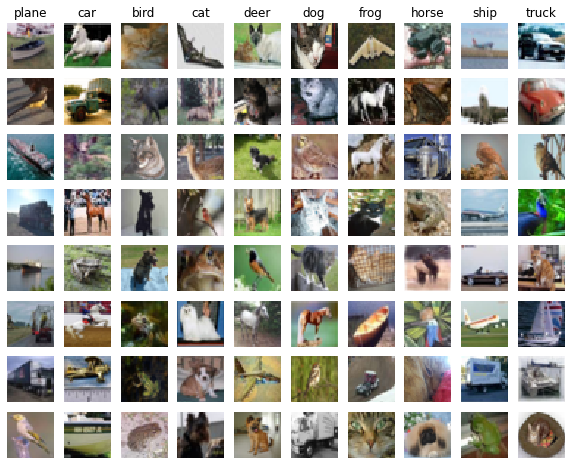

In [10]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ Some of the mistakes make sense: the classfier mistook a car to be a truck, or vice versa. It might be biased towards the shape of the object.




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [11]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302311
iteration 200 / 1000: loss 2.112373
iteration 300 / 1000: loss 1.814990
iteration 400 / 1000: loss 1.621733
iteration 500 / 1000: loss 1.460236
iteration 600 / 1000: loss 1.329697
iteration 700 / 1000: loss 1.398875
iteration 800 / 1000: loss 1.339400
iteration 900 / 1000: loss 1.407965
Validation accuracy:  0.52


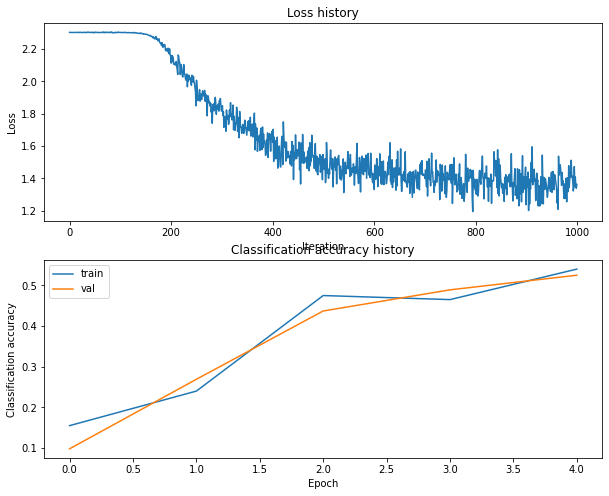

In [23]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10


net = TwoLayerNet(input_dim, hidden_dim, num_classes)
# Train the network
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-1, learning_rate_decay=0.95,
            reg=0.0, verbose=True)
# Predict on the validation set
val_acc = (net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', val_acc)

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [31]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
# hidden_dim = 500
# num_classes = 10

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Below, you should experiment with different values of the various hyperparameters, 
# including hidden layer size, learning rate, numer of training epochs, and regularization strength.

best_val_acc = 0
best_stats = None

input_size = input_dim
num_classes = 10
batch_size = 200

import warnings; warnings.simplefilter('ignore')

lrs = [2e-1, 4e-1, 8e-1]  # 10 ** np.random.uniform(-4,-2,5)
# Train the network
for reg in [0.0]:
    for hidden_size in [250, 500]:
        for num_iters in [2000, 4000]:
            for lr in lrs:
                net = TwoLayerNet(input_size, hidden_size, num_classes)
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                            num_iters=num_iters, batch_size=batch_size,
                            learning_rate=lr, learning_rate_decay=0.95,
                            reg=reg, verbose=False)

                # Predict on the validation set
                val_acc = (net.predict(X_val_feats) == y_val).mean()
                print(f'Validation accuracy: {val_acc}, lr: {lr}, hidden_size: {hidden_size}, num_iters: {num_iters}, reg: {reg}')

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_net = net
                    best_stats = stats

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Validation accuracy: 0.571, lr: 0.2, hidden_size: 250, num_iters: 2000, reg: 0.0
Validation accuracy: 0.579, lr: 0.4, hidden_size: 250, num_iters: 2000, reg: 0.0
Validation accuracy: 0.573, lr: 0.8, hidden_size: 250, num_iters: 2000, reg: 0.0
Validation accuracy: 0.605, lr: 0.2, hidden_size: 250, num_iters: 4000, reg: 0.0
Validation accuracy: 0.587, lr: 0.4, hidden_size: 250, num_iters: 4000, reg: 0.0
Validation accuracy: 0.576, lr: 0.8, hidden_size: 250, num_iters: 4000, reg: 0.0
Validation accuracy: 0.565, lr: 0.2, hidden_size: 500, num_iters: 2000, reg: 0.0
Validation accuracy: 0.594, lr: 0.4, hidden_size: 500, num_iters: 2000, reg: 0.0
Validation accuracy: 0.571, lr: 0.8, hidden_size: 500, num_iters: 2000, reg: 0.0
Validation accuracy: 0.601, lr: 0.2, hidden_size: 500, num_iters: 4000, reg: 0.0
Validation accuracy: 0.582, lr: 0.4, hidden_size: 500, num_iters: 4000, reg: 0.0
Validation accuracy: 0.572, lr: 0.8, hidden_size: 500, num_iters: 4000, reg: 0.0


In [32]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.581


---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [33]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = []

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))